In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quaternion
import sympy
from sympy.abc import x,y,z
from sympy.utilities.codegen import codegen

In [24]:
# path = "../data/tst_cal_005.csv"
# path = "../test/tst_data/data5_tst_cal_004_onArmArbitraryMotions.csv"
# path = "../test/tst_data/data6_tst_cal_004_onArmArbitraryMotions.csv"
path = "../test/tst_data/data7_tst_cal_004_onArmArbitraryMotions.csv"
df = pd.read_csv(path)

# df.head(0)

class Observation:
    def __init__(self,omega1,omega2,q1,q2) -> None:
        self.qR     = q1.conj() * q2
        self.omegaR = quaternion.rotate_vectors(self.qR,omega2) - omega1

obs = []

for i,row in df.iterrows():
    ## Retrieve data from csv file
    omega1 = np.array([ row['IMU_GYROSCOPE(0)_0'], row['IMU_GYROSCOPE(0)_1'], row['IMU_GYROSCOPE(0)_2']] )
    omega2 = np.array([ row['IMU_GYROSCOPE(1)_0'], row['IMU_GYROSCOPE(1)_1'], row['IMU_GYROSCOPE(1)_2']] )
    q1 = np.quaternion(row['IMU_QUATERNION(0)_0'], row['IMU_QUATERNION(0)_1'], row['IMU_QUATERNION(0)_2'], row['IMU_QUATERNION(0)_3'])
    q2 = np.quaternion(row['IMU_QUATERNION(1)_0'], row['IMU_QUATERNION(1)_1'], row['IMU_QUATERNION(1)_2'], row['IMU_QUATERNION(1)_3'])
    ## Add observation to buffer
    obs.append(Observation(omega1,omega2,q1,q2))

## Define equations

In [25]:
theta1,rho1,theta2,rho2 = sympy.symbols('theta_1 rho_1 theta_2 rho_2')
j1 = sympy.Matrix([
        sympy.sin(theta1)*sympy.cos(rho1),
        sympy.sin(theta1)*sympy.sin(rho1),
        sympy.cos(theta1)
    ])
j2 = sympy.Matrix([
        sympy.sin(theta2)*sympy.cos(rho2),
        sympy.sin(theta2)*sympy.sin(rho2),
        sympy.cos(theta2)
    ])
omegaX,omegaY,omegaZ = sympy.symbols('omega_x omega_y omega_z')
omegaR = sympy.Matrix([omegaX, omegaY, omegaZ ])

error_exp = omegaR.dot(j1.cross(j2)) + omegaR.dot(omegaR)*j1.dot(j2)
derr_theta1_exp = sympy.diff(error_exp,theta1)
derr_rho1_exp   = sympy.diff(error_exp,rho1)
derr_theta2_exp = sympy.diff(error_exp,theta2)
derr_rho2_exp   = sympy.diff(error_exp,rho2)

J_col_exp = sympy.Matrix(4,1, [
    derr_theta1_exp, derr_rho1_exp, derr_theta2_exp, derr_rho2_exp
])
J_col_exp

Matrix([
[omega_x*(sin(rho_1)*cos(theta_1)*cos(theta_2) + sin(rho_2)*sin(theta_1)*sin(theta_2)) + omega_y*(-sin(theta_1)*sin(theta_2)*cos(rho_2) - cos(rho_1)*cos(theta_1)*cos(theta_2)) + omega_z*(-sin(rho_1)*sin(theta_2)*cos(rho_2)*cos(theta_1) + sin(rho_2)*sin(theta_2)*cos(rho_1)*cos(theta_1)) + (omega_x**2 + omega_y**2 + omega_z**2)*(sin(rho_1)*sin(rho_2)*sin(theta_2)*cos(theta_1) - sin(theta_1)*cos(theta_2) + sin(theta_2)*cos(rho_1)*cos(rho_2)*cos(theta_1))],
[                                                                                                              omega_x*sin(theta_1)*cos(rho_1)*cos(theta_2) + omega_y*sin(rho_1)*sin(theta_1)*cos(theta_2) + omega_z*(-sin(rho_1)*sin(rho_2)*sin(theta_1)*sin(theta_2) - sin(theta_1)*sin(theta_2)*cos(rho_1)*cos(rho_2)) + (-sin(rho_1)*sin(theta_1)*sin(theta_2)*cos(rho_2) + sin(rho_2)*sin(theta_1)*sin(theta_2)*cos(rho_1))*(omega_x**2 + omega_y**2 + omega_z**2)],
[omega_x*(-sin(rho_1)*sin(theta_1)*sin(theta_2) - sin(rho_2)*cos(theta_1)*c

### Compute lambda functions to be used by the algorithm

In [26]:
# Sympy symbols to be used as arguments of lambdas
vars = [theta1,rho1,theta2,rho2,omegaX,omegaY,omegaZ]
# Error lambda
error = sympy.lambdify(vars, error_exp)
# Error partials of each spherical coord. lambda
J_col = sympy.lambdify(vars,J_col_exp)
# Rotation vector lambda
j_compute = sympy.lambdify([theta1,rho1],j1)

## Agorithm

In [27]:
WINDOW_SIZE = 500
ITERATIONS = 100

In [33]:
RMS = 0

Jacobian     = np.zeros((WINDOW_SIZE,4))
error_vector = np.zeros((WINDOW_SIZE,1))

rand_ang = lambda: np.pi - 2*np.pi*np.random.random()
phi = np.array([
    [rand_ang()],
    [rand_ang()],
    [rand_ang()],
    [rand_ang()]
    ])

j = WINDOW_SIZE
ev = []
while j < df.shape[0]:
    for iteration in range(ITERATIONS):
        for i in range(WINDOW_SIZE):
            ## Calculate error
            e = error(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
            ## Calculate jacobian
            de = J_col(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
            ## Build error vector
            error_vector[i] = e
            ## Build jacobian
            Jacobian[i] = np.transpose(de)

        ev.append(error(*phi,*obs[j].omegaR))
        phi -= np.matmul( np.linalg.pinv(Jacobian), error_vector )

    RMS += error(*phi,*obs[j].omegaR) ** 2
    j += WINDOW_SIZE

RMS = np.sqrt(RMS)/WINDOW_SIZE
phi

array([[-3.90002851],
       [-1.24374465],
       [ 1.45125796],
       [ 0.19967395]])

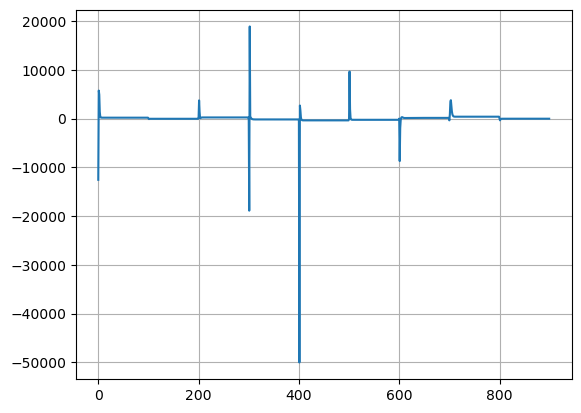

In [34]:
from matplotlib import pyplot as plt
plt.grid(True)
plt.plot(ev)

In [35]:
j_compute(phi[0],phi[1])

array([[[ 0.22095317]],

       [[-0.65132976]],

       [[-0.7259127 ]]])

In [36]:
j_compute(phi[2],phi[3])

array([[[0.97313688]],

       [[0.1969343 ]],

       [[0.11925388]]])

In [37]:
print(f"check for singularities: {np.sin(phi[0])} and {np.sin(phi[2])}")

check for singularities: [0.68778686] and [0.99286379]
